<a href="https://colab.research.google.com/github/duarteleonardosales/Dog_Cat_Classification/blob/main/DUARTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar módulos

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random
import os
import urllib.request

tf.test.gpu_device_name() #testar se GPU está funcionando

''

## Definir variáveis constantes

IMAGE_SIZE = Tamanho das imagens

IMAGE_CHANNELS =  3 (RGB) das cores

SEED = PARA FIXAR A "ALEATORIEDADE"



In [2]:
IMAGE_WIDTH=128 #128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

SEED = 42
np.random.seed(SEED)

## Baixar DataSet das imagens

Fazer uma condição para não baixar/extrair novamente se já existir.


In [3]:
if not os.path.exists('/content/images.tar.gz'):
  urllib.request.urlretrieve("https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", "images.tar.gz")
  !tar -xzf images.tar.gz #unzip o file

## Baixar amostras de Train e Test

Fazer uma condição para não baixar/extrair novamente se já existir.


In [4]:
if not os.path.exists('/content/annotations.tar.gz'):
  urllib.request.urlretrieve("https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", "annotations.tar.gz")
  !tar -xzf annotations.tar.gz #unzip o file

## Preparar amostra de Train

Categorias são as espécies: 1 para gato e 2 para cachorro

In [5]:
url_train = '/content/annotations/trainval.txt'
df_trainval = pd.read_csv(url_train, sep=" ", header=None)
df_trainval.columns = ["filename", "class_id", "categoria", "breed"]
df_trainval = df_trainval[['filename', 'categoria']]
df_trainval['filename'] = df_trainval['filename'].astype(str) + '.jpg'
df_trainval

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,filename,categoria
0,Abyssinian_100.jpg,1
1,Abyssinian_101.jpg,1
2,Abyssinian_102.jpg,1
3,Abyssinian_103.jpg,1
4,Abyssinian_104.jpg,1
...,...,...
3675,yorkshire_terrier_187.jpg,2
3676,yorkshire_terrier_188.jpg,2
3677,yorkshire_terrier_189.jpg,2
3678,yorkshire_terrier_18.jpg,2


## Distribuição da quantidade de dogs e cats na amostra que será dividida em treino e validação

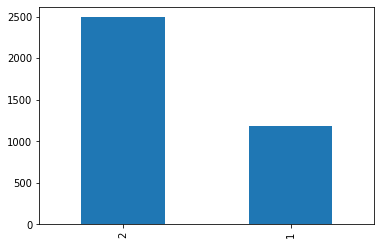

In [6]:
df_trainval['categoria'].value_counts().plot.bar()

## Preparar amostra de Test
Categoria são as espécies: 1 para gato e 2 para cachorro

In [7]:
url_test = '/content/annotations/test.txt'
df_test = pd.read_csv(url_test, sep=" ", header=None)
df_test.columns = ["filename", "class_id", "categoria", "breed"]
df_test = df_test[['filename', 'categoria']]
df_test['filename'] = df_test['filename'].astype(str) + '.jpg'
df_test
nb_samples_test = df_test.shape[0]

## Distribuição da quantidade de dogs e cats na amostra de teste

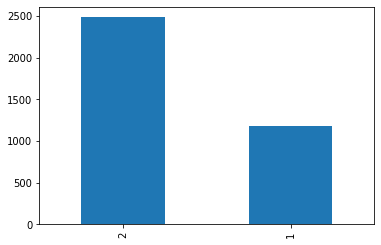

In [8]:
df_test['categoria'].value_counts().plot.bar()

## Construir o Modelo

## CallBacks do modelo = Early Stopping e Learning Rating Reduction

O Early Stopping serve para evitar Overfitting no modelo. Essa condição acontece quando o modelo nao aprende, mas apena "decora" a amostra.

O Learning Rate Reduction ajuda para que os ajustes fiquem mais finos/sensíveis em certos pontos do treinamento quando alguma métrica monitorada para de melhorar.

In [9]:
earlystop = EarlyStopping(patience=20)

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) # min_lr=0.00001

callbacks = [earlystop, lr_reduction]

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu')) #(Conv2D(64, (3, 3)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu')) #(Conv2D(64, (3, 3)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2, activation='softmax')) # 2 - cat e dog.

model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Prepara os dados
### Treinameto --> dados que serão treinados pelo modelo

### Validação --> dados que servirão para validar o modelo durante o treinamento

### Teste --> dados usados para testar o modelo já treinado

#### Será trocado 1 por cat e 2 por dog

In [11]:
df_trainval['categoria'] = df_trainval['categoria'].replace({1: 'cat', 2: 'dog'}) 

## Será separado agora treinamento de validação.

###  0.30 é a porcentagem destinada para validação


In [12]:
train_df, val_df = train_test_split(df_trainval, test_size=0.30, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

## Quantidade de elementos para treinamento (DOG e CAT)

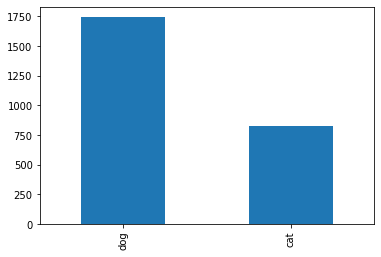

In [13]:
train_df['categoria'].value_counts().plot.bar()

## Quantidade de elementos para validação (DOG e CAT)

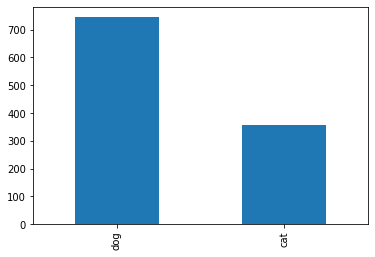

In [14]:
val_df['categoria'].value_counts().plot.bar()

## Aqui será quantificado o total para cada amostra (treino e validação) e definido o tamanho dos lotes de dados (batch_size)

In [15]:
total_train = train_df.shape[0]
total_validate = val_df.shape[0]
batch_size=32 

## Gerador Train -- Serão criadas uma série de variações de imagens que já existem no banco de dados, expandindo assim o repertório de imagens.

### A coluna X passa a ser o nome da imagem e a coluna resposta Y passa a ser a categoria (DOG ou CAT)

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/images", 
    x_col='filename',
    y_col='categoria',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2576 validated image filenames belonging to 2 classes.


## Gerador Validação

### Aqui não foram feitas modificações para expandir o repertório porque essa é a amostra de validação (o modelo não será treinado com essa amostra).

In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    "/content/images", 
    x_col='filename',
    y_col='categoria',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1104 validated image filenames belonging to 2 classes.


## Mostrando como uma única figura pode sofrer variações interessantes para melhorar o aprendizado no modelo


Found 1 validated image filenames belonging to 1 classes.


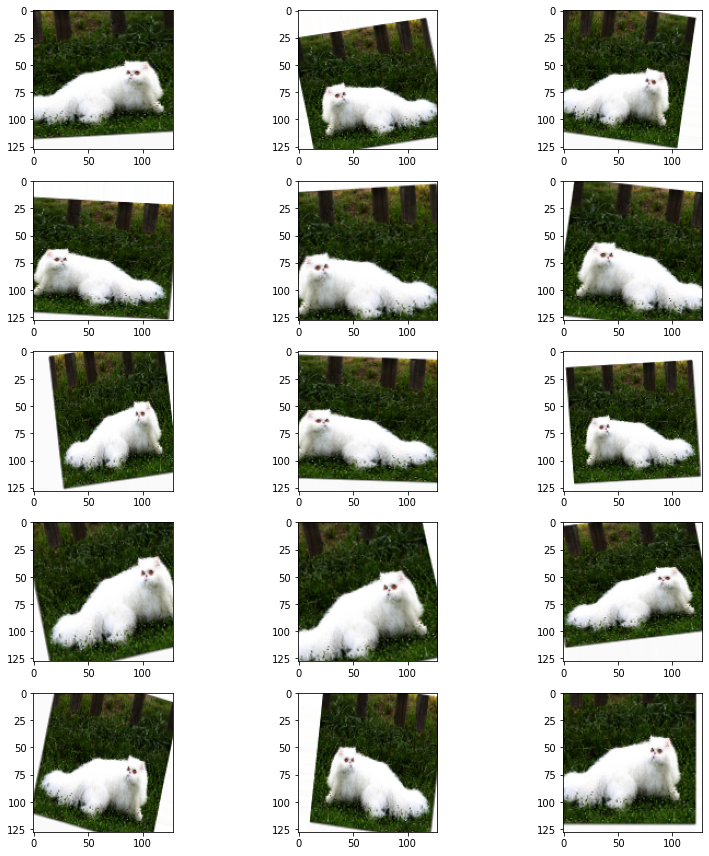

In [18]:
sample_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    sample_df, 
    "/content/images", 
    x_col='filename',
    y_col='categoria',
    target_size=IMAGE_SIZE,
    class_mode='categorical')

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Treinar e salvar o modelo

In [19]:
epochs=50

history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks)

model.save_weights("model.h5")

Epoch 1/50
80/80 [==============================] - 60s 733ms/step - loss: 0.2177 - accuracy: 0.6722 - mse: 0.2177 - val_loss: 0.1973 - val_accuracy: 0.6829 - val_mse: 0.1973 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 57s 711ms/step - loss: 0.2029 - accuracy: 0.6840 - mse: 0.2029 - val_loss: 0.1886 - val_accuracy: 0.6903 - val_mse: 0.1886 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 56s 706ms/step - loss: 0.1945 - accuracy: 0.6977 - mse: 0.1945 - val_loss: 0.1832 - val_accuracy: 0.7142 - val_mse: 0.1832 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - 57s 706ms/step - loss: 0.1929 - accuracy: 0.7115 - mse: 0.1929 - val_loss: 0.1668 - val_accuracy: 0.7390 - val_mse: 0.1668 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 57s 706ms/step - loss: 0.1845 - accuracy: 0.7225 - mse: 0.1845 - val_loss: 0.1652 - val_accuracy: 0.7546 - val_mse: 0.1652 - lr: 0.0010
Epoch 6/50
80/80 [==============================] - 57s 711m

## Visualizar gráfico da métrica MSE

### MSE é o erro quadrátrico. Essa métrica deve diminuir ao longo das épocas.

### Vale ressaltar que há o risco do erro de validação aumentar (levantamento da curva de validação). Esse fenômeno caracteriza o Overfitting. Modelos com esse comportamento não devem ser aceitos.

### Obs.: O EarlyStopping não permitirá que aconteça o levantamento da curva de validação.

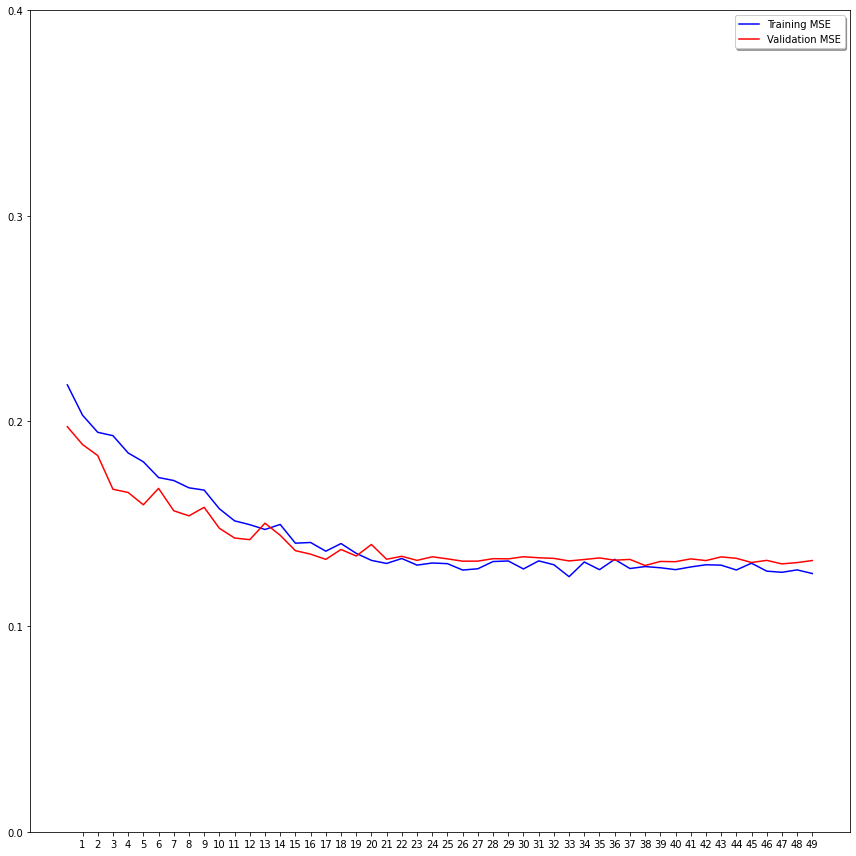

In [34]:
fig, ax1, = plt.subplots(figsize=(12, 12))

ax1.plot(history.history['mse'], color='b', label="Training MSE")
ax1.plot(history.history['val_mse'], color='r', label="Validation MSE")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 0.5, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()

plt.show()

## Visualizar gráfico da Acurácia do modelo

### Essa métrica deve aumentar ao longo das épocas.

### O ideal é que a acurácia do treinamento seja parecida com a de validação.

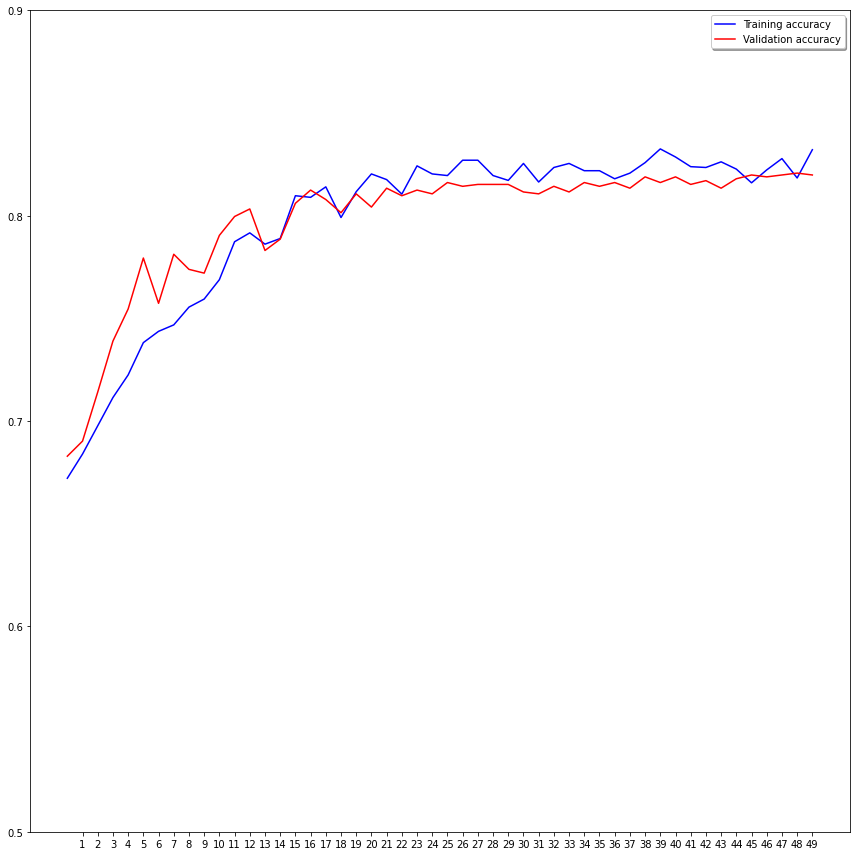

In [35]:
fig, ax2 = plt.subplots(figsize=(12, 12))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0.5, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## R² Treinamento e R² Validação



In [22]:
print(f'O R² de treinamento é = {history.history["accuracy"][-1]}')
print(f'O R² de validação é = {history.history["val_accuracy"][-1]}')

O R² de treinamento é = 0.8321540951728821
O R² de validação é = 0.8198529481887817


## Gerador do teste

In [23]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test, 
    "/content/images", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 3669 validated image filenames.


## Previsão

In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples_test/batch_size))
df_test['categoria'] = np.argmax(predict, axis=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [25]:
df_test['categoria'] = np.argmax(predict, axis=-1)

In [26]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['categoria'] = df_test['categoria'].replace(label_map)

In [27]:
df_test['categoria'] = df_test['categoria'].replace({ 1: 'cat', 2: 'dog' })

## Visualizar graficamente a quantidade de dogs e cats - teste

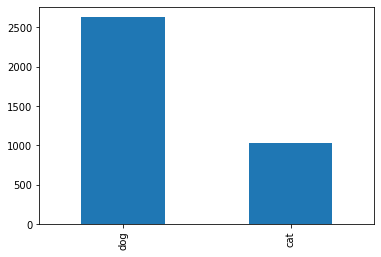

In [28]:
df_test['categoria'].value_counts().plot.bar()

## Exportar CSV com as predições

In [29]:
pred_df = df_test.copy()
pred_df['id'] = pred_df['filename'].str.split('.').str[0]
pred_df['label'] = pred_df['categoria']
pred_df.drop(['filename', 'categoria'], axis=1, inplace=True)
pred_df.to_csv('pred_df.csv', index=False)